<a href="https://colab.research.google.com/github/puzzle91/DL-Project/blob/master/Clean_Diss_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install catboost
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
import time
import timeit
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt

# Classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier


import collections


# Other Libraries
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, TensorBoard
import warnings
warnings.filterwarnings("ignore")




/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
Using TensorFlow backend.


In [0]:
from google.colab import drive
wd = os.getcwd()
print(wd)
drive.mount('/content/drive')


/content
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
cd = os.chdir("drive/My Drive/Dissertation")
wd = os.getcwd()
print(wd)

/content/drive/My Drive/Dissertation


In [0]:
df = pd.read_csv('Diss-Data/unfriendly-CC.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [0]:
import tensorflow as tf
import os

log_dir = 'Dissertations/logs'

if not os.path.exists(log_dir):
    os.makedirs(log_dir)

In [0]:
# Since most of our data has already been scaled we should scale the columns that are left to scale (Amount and Time)
from sklearn.preprocessing import StandardScaler, RobustScaler

# RobustScaler is less prone to outliers.

std_scaler = StandardScaler()
rob_scaler = RobustScaler()

df['scaled_amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1,1))

df.drop(['Time','Amount'], axis=1, inplace=True)

In [0]:
scaled_amount = df['scaled_amount']
scaled_time = df['scaled_time']

df.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True)
df.insert(0, 'scaled_amount', scaled_amount)
df.insert(1, 'scaled_time', scaled_time)

# Amount and Time are Scaled!

df.head()

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

print('No Frauds', round(df['Class'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds', round(df['Class'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

X = df.drop('Class', axis=1)
y = df['Class']

sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

for train_index, test_index in sss.split(X, y):
    print("Train:", train_index, "Test:", test_index)
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]

# We already have X_train and y_train for undersample data thats why I am using original
#to distinguish and to not overwrite these variables.
# original_Xtrain, original_Xtest, original_ytrain, original_ytest 
#= train_test_split(X, y, test_size=0.2, random_state=42)

# Check the Distribution of the labels


# Turn into an array
original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values

# See if both the train and test label distribution are similarly distributed
train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts=True)
test_unique_label, test_counts_label = np.unique(original_ytest, return_counts=True)
print('-' * 100)

print('Label Distributions: \n')
print(train_counts_label/ len(original_ytrain))
print(test_counts_label/ len(original_ytest))

No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset
Train: [ 30473  30496  31002 ... 284804 284805 284806] Test: [    0     1     2 ... 57017 57018 57019]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 30473  30496  31002 ... 113964 113965 113966]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 81609  82400  83053 ... 170946 170947 170948]
Train: [     0      1      2 ... 284804 284805 284806] Test: [150654 150660 150661 ... 227866 227867 227868]
Train: [     0      1      2 ... 227866 227867 227868] Test: [212516 212644 213092 ... 284804 284805 284806]
----------------------------------------------------------------------------------------------------
Label Distributions: 

[0.99827076 0.00172924]
[0.99827952 0.00172048]


In [0]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, RandomizedSearchCV


print('Length of X (train): {} | Length of y (train): {}'.format(len(original_Xtrain), len(original_ytrain)))
print('Length of X (test): {} | Length of y (test): {}'.format(len(original_Xtest), len(original_ytest)))

# List to append the score and then find the average
accuracy_lst = []
precision_lst = []
recall_lst = []
f1_lst = []
auc_lst = []

t0 = time.time()


catboost_model = CatBoostClassifier(task_type='GPU')
parameters = {'depth': sp_randInt(4, 10),
                    'learning_rate' : sp_randFloat(),
                    'iterations'    : sp_randInt(10, 100)
                         }
rand_catboost = RandomizedSearchCV(estimator=catboost_model, param_distributions = parameters,
                             n_jobs=-1, cv = 5)


# Parameters
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
# Classifier with optimal parameters
# log_reg_sm = grid_log_reg.best_estimator_
log_reg_sm = LogisticRegression()

rand_log_reg = RandomizedSearchCV(LogisticRegression(), log_reg_params, n_iter=4)


# Implementing SMOTE Technique 
# Cross Validating the right way

for train, test in sss.split(original_Xtrain, original_ytrain):
    pipeline = imbalanced_make_pipeline(SMOTE(sampling_strategy='minority'), rand_log_reg) # SMOTE happens during Cross Validation not before..
    model = pipeline.fit(original_Xtrain[train], original_ytrain[train])
    log_reg_best_est = rand_log_reg.best_estimator_
    prediction = log_reg_best_est.predict(original_Xtrain[test])
    
    accuracy_lst.append(pipeline.score(original_Xtrain[test], original_ytrain[test]))
    precision_lst.append(precision_score(original_ytrain[test], prediction))
    recall_lst.append(recall_score(original_ytrain[test], prediction))
    f1_lst.append(f1_score(original_ytrain[test], prediction))
    auc_lst.append(roc_auc_score(original_ytrain[test], prediction))
    
print('---' * 15)
print('')
print("accuracy: {}".format(np.mean(accuracy_lst)))
print("precision: {}".format(np.mean(precision_lst)))
print("recall: {}".format(np.mean(recall_lst)))
print("f1: {}".format(np.mean(f1_lst)))
print('---' * 45)

t1 = time.time()
print("Fitting Log Regression model with oversample data from SMOTE X_train, y_train took :{} sec".format(t1 - t0))

Length of X (train): 227846 | Length of y (train): 227846
Length of X (test): 56961 | Length of y (test): 56961
---------------------------------------------

accuracy: 0.9462185714758503
precision: 0.05485517770713094
recall: 0.9136319376825707
f1: 0.1020559863862935
---------------------------------------------------------------------------------------------------------------------------------------
Fitting Regression model with oversample data from SMOTE X_train, y_train took :388.56642484664917 sec


In [0]:
log_reg_pred  = log_reg_best_est.predict(original_Xtest)

print('Log Regression Model AUC score: ', roc_auc_score(original_ytest, log_reg_pred))


print('Log Regression Model Classification Report:')


print(classification_report(original_ytest, log_reg_pred))

CatBoostClassifer AUC score:  0.9217324884335317
CatboostClassifer Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56863
           1       0.06      0.87      0.11        98

    accuracy                           0.98     56961
   macro avg       0.53      0.92      0.55     56961
weighted avg       1.00      0.98      0.99     56961



In [0]:

# List to append the score and then find the average
accuracy_lst = []
precision_lst = []
recall_lst = []
f1_lst = []
auc_lst = []

t0 = time.time()


catboost_model = CatBoostClassifier(task_type='GPU')

parameters = {'depth': sp_randInt(4, 10),
                    'learning_rate' : sp_randFloat(),
                    'iterations'    : sp_randInt(10, 100)}
                         
rand_catboost = RandomizedSearchCV(estimator=catboost_model, param_distributions = parameters,
                             n_jobs=-1)



# Implementing SMOTE Technique 
# Cross Validating the right way
# Parameters:


for train, test in sss.split(original_Xtrain, original_ytrain):
    pipeline = imbalanced_make_pipeline(SMOTE(sampling_strategy='minority'), rand_catboost) # SMOTE happens during Cross Validation not before..
    model = pipeline.fit(original_Xtrain[train], original_ytrain[train])
    catboost_best_est = rand_catboost.best_estimator_
    prediction = catboost_best_est.predict(original_Xtrain[test])
    
    accuracy_lst.append(pipeline.score(original_Xtrain[test], original_ytrain[test]))
    precision_lst.append(precision_score(original_ytrain[test], prediction))
    recall_lst.append(recall_score(original_ytrain[test], prediction))
    f1_lst.append(f1_score(original_ytrain[test], prediction))
    auc_lst.append(roc_auc_score(original_ytrain[test], prediction))
    
print('---' * 15)
print('')
print("accuracy: {}".format(np.mean(accuracy_lst)))
print("precision: {}".format(np.mean(precision_lst)))
print("recall: {}".format(np.mean(recall_lst)))
print("f1: {}".format(np.mean(f1_lst)))
print('---' * 45)

t1 = time.time()
print("Fitting Catboost Classifier model with oversample data from SMOTE X_train, y_train took :{} sec".format(t1 - t0))

0:	learn: 0.1387806	total: 25ms	remaining: 2.05s
1:	learn: 0.0900893	total: 47ms	remaining: 1.9s
2:	learn: 0.0633832	total: 69.2ms	remaining: 1.84s
3:	learn: 0.0476709	total: 92.7ms	remaining: 1.83s
4:	learn: 0.0383248	total: 116ms	remaining: 1.8s
5:	learn: 0.0321555	total: 138ms	remaining: 1.78s
6:	learn: 0.0246993	total: 162ms	remaining: 1.76s
7:	learn: 0.0187781	total: 186ms	remaining: 1.74s
8:	learn: 0.0152534	total: 209ms	remaining: 1.72s
9:	learn: 0.0137991	total: 237ms	remaining: 1.73s
10:	learn: 0.0124773	total: 259ms	remaining: 1.69s
11:	learn: 0.0100769	total: 282ms	remaining: 1.67s
12:	learn: 0.0087151	total: 305ms	remaining: 1.64s
13:	learn: 0.0077854	total: 328ms	remaining: 1.62s
14:	learn: 0.0070612	total: 350ms	remaining: 1.59s
15:	learn: 0.0065534	total: 373ms	remaining: 1.56s
16:	learn: 0.0061391	total: 395ms	remaining: 1.53s
17:	learn: 0.0054718	total: 418ms	remaining: 1.51s
18:	learn: 0.0050207	total: 445ms	remaining: 1.5s
19:	learn: 0.0047738	total: 476ms	remaining:

In [79]:
catboost_pred  = catboost_best_est.predict(original_Xtest, prediction_type='Class')

print('CatBoostClassifer AUC score: ', roc_auc_score(original_ytest, catboost_pred))


print('CatboostClassifer Classification Report:')


print(classification_report(original_ytest, catboost_pred))

CatBoostClassifer AUC score:  0.8315711016130068
CatboostClassifer Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.90      0.66      0.76        98

    accuracy                           1.00     56961
   macro avg       0.95      0.83      0.88     56961
weighted avg       1.00      1.00      1.00     56961



In [0]:
import itertools
from sklearn.metrics import confusion_matrix

# Create a confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=14)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[56856     7]
 [   33    65]]
Confusion matrix, without normalization
[[55505  1358]
 [   13    85]]


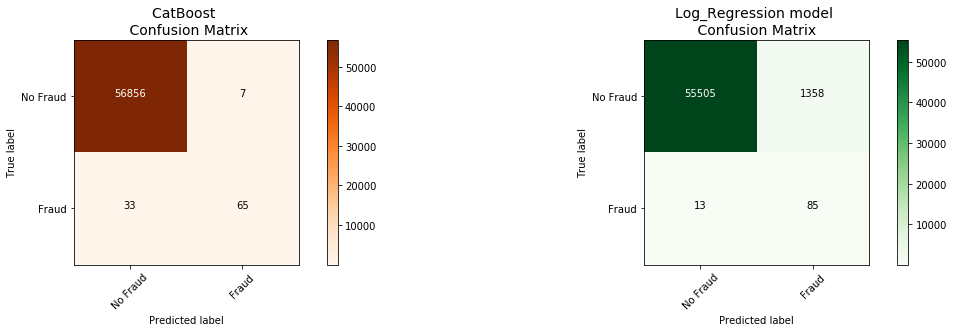

In [0]:
catboost_cm = confusion_matrix(original_ytest, catboost_pred)
log_reg_cm = confusion_matrix(original_ytest, log_reg_pred)
labels = ['No Fraud', 'Fraud']

fig = plt.figure(figsize=(16,8))

fig.add_subplot(221)
plot_confusion_matrix(catboost_cm, labels, title="CatBoost \n Confusion Matrix", cmap=plt.cm.Oranges)

fig.add_subplot(222)
plot_confusion_matrix(log_reg_cm, labels, title="Log_Regression model \n Confusion Matrix ", cmap=plt.cm.Greens)

In [0]:
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy

n_inputs = original_Xtrain.shape[1]

nn_model = Sequential([
    Dense(n_inputs, input_shape=(n_inputs, ), activation='relu'),
    Dense(32, activation='relu'),
    Dense(2, activation='softmax')
])

W0829 14:15:13.170742 140045315323776 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0829 14:15:13.197473 140045315323776 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0829 14:15:13.201961 140045315323776 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



In [0]:
# SMOTE Technique (OverSampling) After splitting and Cross Validating
sm = SMOTE(ratio='minority', random_state=42)
# Xsm_train, ysm_train = sm.fit_sample(X_train, y_train)


# This will be the data were we are going to train our models with: 
Xsm_train, ysm_train = sm.fit_sample(original_Xtrain, original_ytrain)


print('Length of Orignal X (train): {} | Length of Orignal y (train): {}'.format(len(original_Xtrain), len(original_ytrain)))
print('Length of Orignal X (test): {} | Length of Orignal y (test): {}'.format(len(original_Xtrain), len(original_ytrain)))

print("---*"*50)
print('Length of SMOTE X (train): {} | Length of SMOTE y (train): {}'.format(len(Xsm_train), len(ysm_train)))
print('Length of SMOTE X (test): {} | Length of SMOTE y (test): {}'.format(len(Xsm_train), len(ysm_train)))


Length of Orignal X (train): 227846 | Length of Orignal y (train): 227846
Length of Orignal X (test): 227846 | Length of Orignal y (test): 227846
---*---*---*---*---*---*---*---*---*---*---*---*---*---*---*---*---*---*---*---*---*---*---*---*---*---*---*---*---*---*---*---*---*---*---*---*---*---*---*---*---*---*---*---*---*---*---*---*---*---*
Length of SMOTE X (train): 454904 | Length of SMOTE y (train): 454904
Length of SMOTE X (test): 454904 | Length of SMOTE y (test): 454904


In [0]:
t0 = time.time()

nn_model.compile(Adam(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
nn_model.fit(Xsm_train, ysm_train, validation_split=0.2, batch_size=25, epochs=20, shuffle=True, verbose=2)



t1 = time.time()
print("Fitting Neural Network model with oversample data from SMOTE X_train, y_train took :{} sec".format(t1 - t0))

Train on 363923 samples, validate on 90981 samples
Epoch 1/20
 - 57s - loss: 0.0049 - acc: 0.9991 - val_loss: 5.9889e-04 - val_acc: 1.0000
Epoch 2/20
 - 56s - loss: 0.0035 - acc: 0.9992 - val_loss: 0.0025 - val_acc: 0.9996
Epoch 3/20
 - 56s - loss: 0.0030 - acc: 0.9994 - val_loss: 0.0013 - val_acc: 1.0000
Epoch 4/20
 - 55s - loss: 0.0026 - acc: 0.9995 - val_loss: 3.8840e-04 - val_acc: 1.0000
Epoch 5/20
 - 56s - loss: 0.0022 - acc: 0.9995 - val_loss: 0.0022 - val_acc: 0.9997
Epoch 6/20
 - 56s - loss: 0.0022 - acc: 0.9995 - val_loss: 4.1056e-04 - val_acc: 1.0000
Epoch 7/20
 - 55s - loss: 0.0025 - acc: 0.9996 - val_loss: 4.9031e-04 - val_acc: 1.0000
Epoch 8/20
 - 56s - loss: 0.0018 - acc: 0.9996 - val_loss: 1.3904e-04 - val_acc: 1.0000
Epoch 9/20
 - 55s - loss: 0.0017 - acc: 0.9996 - val_loss: 0.0070 - val_acc: 0.9977
Epoch 10/20
 - 55s - loss: 0.0017 - acc: 0.9996 - val_loss: 1.6929e-04 - val_acc: 1.0000
Epoch 11/20
 - 55s - loss: 0.0017 - acc: 0.9997 - val_loss: 1.8350e-04 - val_acc: 1.

In [0]:
nn_model_predictions = nn_model.predict(original_Xtest, batch_size=200, verbose=0)
nn_model_fraud_predictions = nn_model.predict_classes(original_Xtest, batch_size=200, verbose=0)


Confusion matrix, without normalization
[[56849    14]
 [   29    69]]
Confusion matrix, without normalization
[[56863     0]
 [    0    98]]


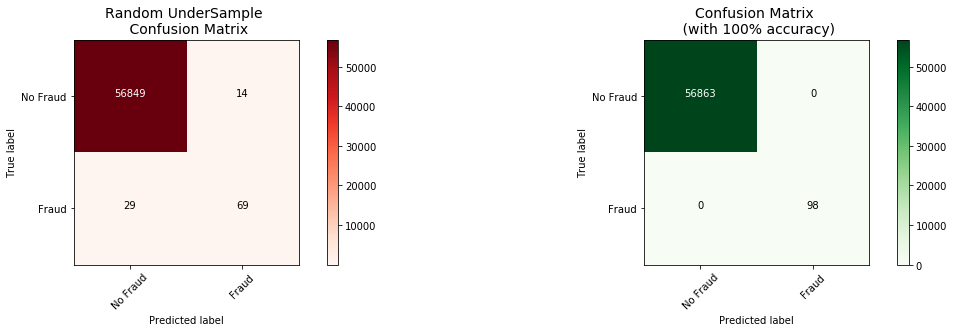

In [0]:
nn_cm = confusion_matrix(original_ytest, nn_model_fraud_predictions)
actual_cm = confusion_matrix(original_ytest, original_ytest)
labels = ['No Fraud', 'Fraud']

fig = plt.figure(figsize=(16,8))

fig.add_subplot(221)
plot_confusion_matrix(nn_cm, labels, title="Random UnderSample \n Confusion Matrix", cmap=plt.cm.Reds)

fig.add_subplot(222)
plot_confusion_matrix(actual_cm, labels, title="Confusion Matrix \n (with 100% accuracy)", cmap=plt.cm.Greens)

In [0]:

print('Neural Network AUC score:', roc_auc_score(original_ytest, nn_model_fraud_predictions))


print('Neural Network Classification Report:')


print(classification_report(original_ytest, nn_model_fraud_predictions))


Neural Network AUC score: 0.8519177134300953
Neural Network Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.83      0.70      0.76        98

    accuracy                           1.00     56961
   macro avg       0.92      0.85      0.88     56961
weighted avg       1.00      1.00      1.00     56961



Confusion matrix, without normalization
[[56856     7]
 [   33    65]]
Confusion matrix, without normalization
[[55505  1358]
 [   13    85]]
Confusion matrix, without normalization
[[56849    14]
 [   29    69]]
Confusion matrix, without normalization
[[56863     0]
 [    0    98]]


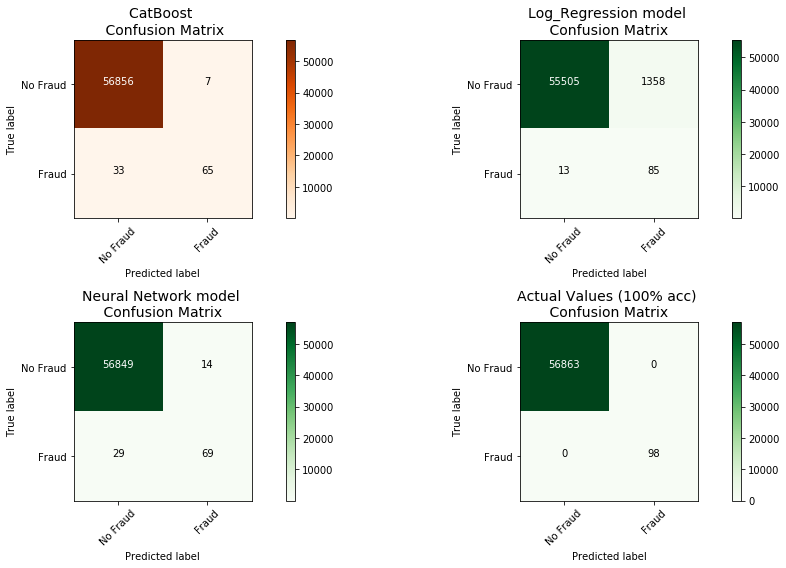

In [0]:
catboost_cm = confusion_matrix(original_ytest, catboost_pred)
log_reg_cm = confusion_matrix(original_ytest, log_reg_pred)
nn_cm = confusion_matrix(original_ytest, nn_model_fraud_predictions)
actual_cm = confusion_matrix(original_ytest, original_ytest)
labels = ['No Fraud', 'Fraud']

fig = plt.figure(figsize=(16,8))

fig.add_subplot(221)
plot_confusion_matrix(catboost_cm, labels, title="CatBoost \n Confusion Matrix", cmap=plt.cm.Oranges)

fig.add_subplot(222)
plot_confusion_matrix(log_reg_cm, labels, title="Log_Regression model \n Confusion Matrix ", cmap=plt.cm.Greens)

fig.add_subplot(223)
plot_confusion_matrix(nn_cm, labels, title="Neural Network model \n Confusion Matrix ", cmap=plt.cm.Greens)


fig.add_subplot(224)
plot_confusion_matrix(actual_cm, labels, title="Actual Values (100% acc) \n Confusion Matrix ", cmap=plt.cm.Greens)

In [0]:
print('CatBoostClassifer AUC score: ', roc_auc_score(original_ytest, catboost_pred))


print("-"*10)

print('NN model ROC AUC score: ', roc_auc_score(original_ytest, nn_model_fraud_predictions))

print("-"*10)
print('Log Reg model ROC AUC score: ', roc_auc_score(original_ytest, log_reg_pred))


CatBoostClassifer AUC score:  0.8315711016130068
----------
NN model ROC AUC score:  0.8519177134300953
----------
Log Reg model ROC AUC score:  0.9217324884335317


Fitting 4 folds for each of 24 candidates, totalling 96 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   48.6s
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:  2.1min finished


{'boosting_type': 'gbdt', 'colsample_bytree': 0.64, 'learning_rate': 0.07, 'n_estimators': 8, 'num_leaves': 27, 'objective': 'binary', 'random_state': 501, 'subsample': 0.7}
0.8460114661554965
Fitting with params: 
{'boosting_type': 'gbdt', 'max_depth': -1, 'objective': 'binary', 'nthread': 5, 'num_leaves': 27, 'learning_rate': 0.07, 'max_bin': 512, 'subsample_for_bin': 200, 'subsample': 0.7, 'subsample_freq': 1, 'colsample_bytree': 0.64, 'reg_alpha': 1.2, 'reg_lambda': 1.2, 'min_split_gain': 0.5, 'min_child_weight': 1, 'min_child_samples': 5, 'scale_pos_weight': 1, 'num_class': 1, 'metric': 'binary_error'}
Overall accuracy of Light GBM model: 0.999420656238479


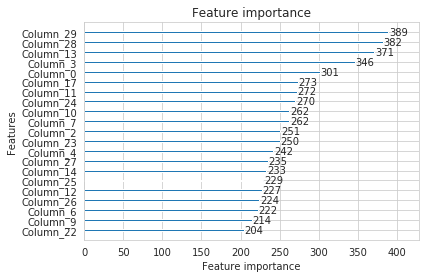

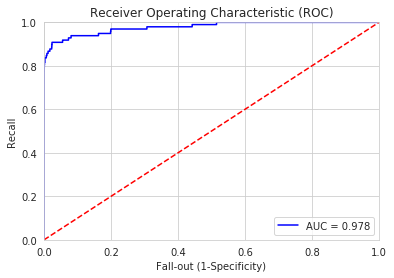

AUC score: 0.977982706017004


<Figure size 432x288 with 0 Axes>

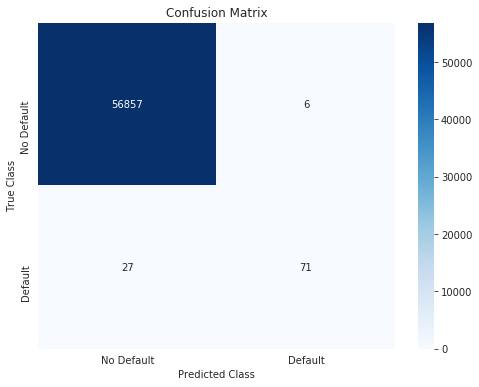

In [0]:
!pip install lightgbm
from sklearn.metrics import confusion_matrix,accuracy_score, roc_curve, auc
sns.set_style("whitegrid")

import lightgbm as lgb
from sklearn.model_selection import  GridSearchCV
#------------------------Build LightGBM Model-----------------------
train_data=lgb.Dataset(Xsm_train, label=ysm_train)

#Select Hyper-Parameters
params = {'boosting_type': 'gbdt',
          'max_depth' : -1,
          'objective': 'binary',
          'nthread': 5,
          'num_leaves': 64,
          'learning_rate': 0.07,
          'max_bin': 512,
          'subsample_for_bin': 200,
          'subsample': 1,
          'subsample_freq': 1,
          'colsample_bytree': 0.8,
          'reg_alpha': 1.2,
          'reg_lambda': 1.2,
          'min_split_gain': 0.5,
          'min_child_weight': 1,
          'min_child_samples': 5,
          'scale_pos_weight': 1,
          'num_class' : 1,
          'metric' : 'binary_error'
          }

# Create parameters to search
gridParams = {
    'learning_rate': [0.07],
    'n_estimators': [8,16],
    'num_leaves': [20, 24, 27],
    'boosting_type' : ['gbdt'],
    'objective' : ['binary'],
    'random_state' : [501], 
    'colsample_bytree' : [0.64, 0.65],
    'subsample' : [0.7,0.75],
    #'reg_alpha' : [1, 1.2],
    #'reg_lambda' : [ 1.2, 1.4],
    }

# Create classifier to use
mdl = lgb.LGBMClassifier(boosting_type= 'gbdt',
          objective = 'binary',
          n_jobs = 5, 
          silent = True,
          max_depth = params['max_depth'],
          max_bin = params['max_bin'],
          subsample_for_bin = params['subsample_for_bin'],
          subsample = params['subsample'],
          subsample_freq = params['subsample_freq'],
          min_split_gain = params['min_split_gain'],
          min_child_weight = params['min_child_weight'],
          min_child_samples = params['min_child_samples'],
          scale_pos_weight = params['scale_pos_weight'])

# View the default model params:
mdl.get_params().keys()

# Create the grid
grid = GridSearchCV(mdl, gridParams, verbose=2, cv=4, n_jobs=-1)

# Run the grid
grid.fit(Xsm_train, ysm_train)

# Print the best parameters found
print(grid.best_params_)
print(grid.best_score_)

# Using parameters already set above, replace in the best from the grid search
params['colsample_bytree'] = grid.best_params_['colsample_bytree']
params['learning_rate'] = grid.best_params_['learning_rate']
# params['max_bin'] = grid.best_params_['max_bin']
params['num_leaves'] = grid.best_params_['num_leaves']
#params['reg_alpha'] = grid.best_params_['reg_alpha']
#params['reg_lambda'] = grid.best_params_['reg_lambda']
params['subsample'] = grid.best_params_['subsample']
# params['subsample_for_bin'] = grid.best_params_['subsample_for_bin']

print('Fitting with params: ')
print(params)

#Train model on selected parameters and number of iterations
lgbm = lgb.train(params,
                 train_data,
                 280,
                 #early_stopping_rounds= 40,
                 verbose_eval= 4
                 )

#Predict on test set
predictions_lgbm_prob = lgbm.predict(original_Xtest)
predictions_lgbm_01 = np.where(predictions_lgbm_prob > 0.5, 1, 0) #Turn probability to 0-1 binary output

#--------------------------Print accuracy measures and variable importances----------------------
#Plot Variable Importances
lgb.plot_importance(lgbm, max_num_features=21, importance_type='split')

#Print accuracy
acc_lgbm = accuracy_score(original_ytest, predictions_lgbm_01)
print('Overall accuracy of Light GBM model:', acc_lgbm)

#Print Area Under Curve
plt.figure()
false_positive_rate, recall, thresholds = roc_curve(original_ytest, predictions_lgbm_prob)
roc_auc = auc(false_positive_rate, recall)
plt.title('Receiver Operating Characteristic (ROC)')
plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.3f' %roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out (1-Specificity)')
plt.show()

print('AUC score:', roc_auc)

#Print Confusion Matrix
plt.figure()
cm = confusion_matrix(original_ytest, predictions_lgbm_01)
labels = ['No Default', 'Default']
plt.figure(figsize=(8,6))
sns.heatmap(cm, xticklabels = labels, yticklabels = labels, annot = True, fmt='d', cmap="Blues", vmin = 0.2);
plt.title('Confusion Matrix')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

In [60]:
!pip install xgboost
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score

In [63]:


print("starting training")
model = XGBClassifier()
kfold = StratifiedKFold(n_splits=5, random_state=7)
t0 = time.time()
# use area under the precision-recall curve to show classification accuracy
scoring = 'roc_auc'
results = cross_val_score(model, Xsm_train, ysm_train, cv=kfold, scoring = scoring)
t1 = time.time()


print("Fitting XGBoost with data from SMOTE X_train, y_train took :{} sec".format(t1 - t0))
print( "AUC: %.3f (%.3f)" % (results.mean(), results.std()) )

starting training
Fitting XGBoost with data from SMOTE X_train, y_train took :479.4112627506256 sec
AUC: 0.990 (0.005)


In [0]:
model = XGBClassifier()
model.fit(Xsm_train, ysm_train)
XGB_pred = model.predict(original_Xtest)

In [0]:
# change size of Matplotlib plot
fig_size = plt.rcParams["figure.figsize"] # Get current size

old_fig_params = fig_size
# new figure parameters
fig_size[0] = 12
fig_size[1] = 9
   
plt.rcParams["figure.figsize"] = fig_size # set new size

In [96]:
print('CatBoostClassifer AUC score: ', roc_auc_score(original_ytest, catboost_pred))


print("-"*10)

print('NN model ROC AUC score: ', roc_auc_score(original_ytest, nn_model_fraud_predictions))

print("-"*10)
print('Log Reg model ROC AUC score: ', roc_auc_score(original_ytest, log_reg_pred))

print("-"*10)
print('LGBM model ROC AUC score: ', roc_auc_score(original_ytest, predictions_lgbm_01))

print("-"*10)
print('XGBoost model ROC AUC score: ', roc_auc_score(original_ytest, XGB_pred))



CatBoostClassifer AUC score:  0.8315711016130068
----------
NN model ROC AUC score:  0.8519177134300953
----------
Log Reg model ROC AUC score:  0.9217324884335317
----------
LGBM model ROC AUC score:  0.8621921395749972
----------
XGBoost model ROC AUC score:  0.8975547027280392


In [0]:
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_predict

cat_fpr, cat_tpr, cat_threshold = roc_curve(original_ytest, catboost_pred)
log_fpr, log_tpr, log_threshold = roc_curve(original_ytest, log_reg_pred)
nn_fpr, nn_tpr, nn_threshold = roc_curve(original_ytest, nn_model_fraud_predictions)
lgbm_fpr, lgbm_tpr, lgbm_threshold = roc_curve(original_ytest, predictions_lgbm_01)
xgb_fpr, xgb_tpr, xgb_threshold = roc_curve(original_ytest, XGB_pred)



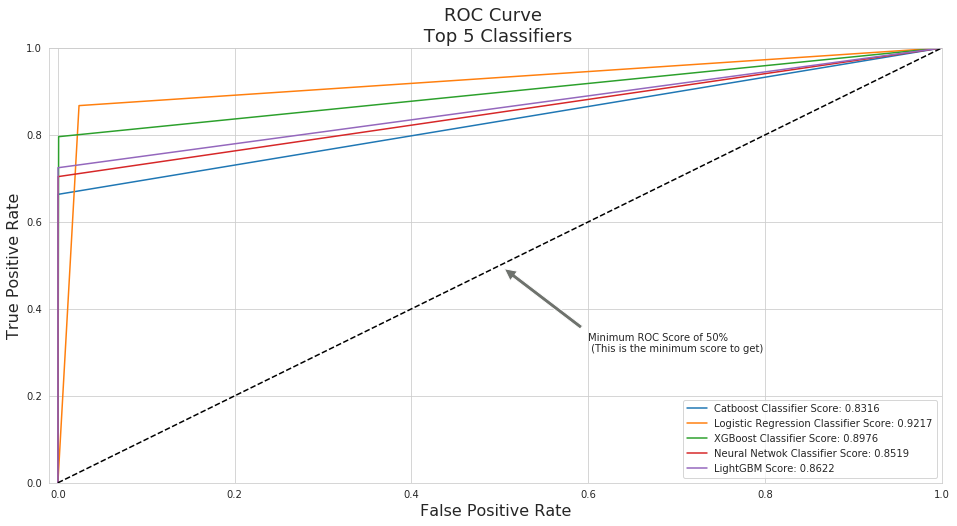

In [93]:
def graph_roc_curve_multiple(cat_fpr, cat_tpr, log_fpr, log_tpr, nn_fpr, nn_tpr, lgbm_fpr, lgbm_tpr, xgb_fpr, xgb_tpr):
    plt.figure(figsize=(16,8))
    plt.title('ROC Curve \n Top 5 Classifiers', fontsize=18)
    plt.plot(cat_fpr, cat_tpr, label='Catboost Classifier Score: {:.4f}'.format(roc_auc_score(original_ytest, catboost_pred)))

    plt.plot(log_fpr, log_tpr, label='Logistic Regression Classifier Score: {:.4f}'.format(roc_auc_score(original_ytest, log_reg_pred)))
    plt.plot(xgb_fpr, xgb_tpr, label='XGBoost Classifier Score: {:.4f}'.format(roc_auc_score(original_ytest, XGB_pred)))
    plt.plot(nn_fpr, nn_tpr, label='Neural Netwok Classifier Score: {:.4f}'.format(roc_auc_score(original_ytest, nn_model_fraud_predictions)))
    plt.plot(lgbm_fpr, lgbm_tpr, label='LightGBM Score: {:.4f}'.format(roc_auc_score(original_ytest, predictions_lgbm_01)))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.01, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.annotate('Minimum ROC Score of 50% \n (This is the minimum score to get)', xy=(0.5, 0.5), xytext=(0.6, 0.3),
                arrowprops=dict(facecolor='#6E726D', shrink=0.05),
                )
    plt.legend()
    
graph_roc_curve_multiple(cat_fpr, cat_tpr, log_fpr, log_tpr, nn_fpr, nn_tpr, lgbm_fpr, lgbm_tpr, xgb_fpr, xgb_tpr)
plt.show()

In [95]:

print('Logistic Regression: ', roc_auc_score(original_ytest, log_reg_pred))
print('CatBoost Classifier: ', roc_auc_score(original_ytest, catboost_pred))
print('Neural Network: ', roc_auc_score(original_ytest, nn_model_fraud_predictions))
print('LightGBM: ', roc_auc_score(original_ytest, predictions_lgbm_01))
print('Decision Tree Classifier: ', roc_auc_score(original_ytest, XGB_pred))

Logistic Regression:  0.9217324884335317
CatBoost Classifier:  0.8315711016130068
Neural Network:  0.8519177134300953
LightGBM:  0.8621921395749972
Decision Tree Classifier:  0.8975547027280392
